This file contains the code to investigate how the system is affected in a construct where the operon is removed, and instead replaced by one which is activated by not SigV but by some controlable induction agent (like IPTG). This let's us investigate an operon where the feedback is removed.

# Preparations

### Fetch Packages and Files

In [1]:
# Fetch the required julia packages (packages can be added by "> using Pkg, Pkg.add("PackageName")").
using DiffEqBase
using DiffEqJump
using Plots
using Plots.Measures
using Serialization
using Statistics
gr(); default(fmt = :png);

In [2]:
# Loads the files with the required functions for this project.
include("Functions/sigV_model.jl")     # This file declares the model.
include("Functions/simulate.jl")       # This fule contains the functions for simulating the model.
include("Functions/make_plots.jl");    # This file contains the function for creating the plots.
include("Functions/make_csvs.jl");     # This file contains the function for re-saving simulations as csv files (if one wishes to access them from other programming langauges).

### Sets File Destination

In [3]:
# Sets folder where the simulations are saved.
data_folder = "../Data/";

In [4]:
# Sets folder where the figures are saved.
figure_folder = "../Figures/"; 

### Set Parameters

In [5]:
v0 = 0.1; v = 2.5; K = 60; n = 2;
kD = 5; kB = 10; kC = 0.05;
deg = 0.01; L = 0.; 
p = [v0,v,K,n,kD,kB,kC,deg,L];

# Analysis

In [6]:
m = 100;
l = 4000.; 
induction_amounts = 0.2:0.2:5.;                      # Sets the various amounts of induction (corresponding to direct change in operon activity, where 2.5 is the base maximum activity of the wt operon). 
only_inducible_p = vcat(copy(p),[0.,0.]);            # Prepares the parameters of the inducible only strain.
only_inducible_p[1] = 0.; only_inducible_p[2] = 0.;  # Prepares the parameters of the inducible only strain.

In [7]:
# Simulates the wildtype activation (for reference).
@time sols_WT = ssa_monte(p,(-500.,l-500.),m,((0.,1.),));
serialize(data_folder*"induced_additional_operon_only/wt_activation.jls",sols_WT)
plot_sims(sols_WT,ylimit=(0,250)); plot_WT_activation = plot_stress_pattern!([0],[],250)

 17.227535 seconds (7.27 M allocations: 423.076 MiB, 0.93% gc time)


In [8]:
# Makes the simulations for various induction strengths.
@time for ia in induction_amounts
    sols_internal = ssa_monte_p_steps(only_inducible_p,(-500.,l - 500.),m,((10,0.,ia),(11,0.,ia),(9,1500.,1.)));
    serialize(data_folder*"induced_additional_operon_only/sols_induction"*string(ia)*".jls",sols_internal)
end

1596.341097 seconds (40.76 M allocations: 2.413 GiB, 0.04% gc time)


In [7]:
# Loads the simulations into a vector.
induced_only_sols = map(ia -> deserialize(data_folder*"induced_additional_operon_only/sols_induction"*string(ia)*".jls"), induction_amounts);
sols_WT = deserialize(data_folder*"induced_additional_operon_only/wt_activation.jls");     # Fetches the wild type activation data (for reference).

In [8]:
# Plots the activation pattern for various induction strengths (induction start at time 0, stress added at time 1500).
induced_only_plots = map(i -> (plot_stress_induction_pattern([1500],[],[0],250); plot_sims!(induced_only_sols[i],title="Induction amount: "*string(induction_amounts[i]));), 1:length(induction_amounts));
induced_only_activations_plot = plot(induced_only_plots[1:16]...,size=(1600,1000),ylimit=(0,250),guidefontsize=11,titlefontsize=12,right_margin=5mm,left_margin=5mm,bottom_margin=5mm,layout=@layout grid(4,4))

In [9]:
# Saves the figures.
savefig(induced_only_activations_plot,figure_folder*"induced_additional_operon_only/induced_operon_only_actiavtion_figures.png");
savefig(induced_only_activations_plot,figure_folder*"induced_additional_operon_only/induced_operon_only_actiavtion_figures.svg");

In [10]:
# Calculates Fold changes in mean activity from their steady states levels before stress (but after induction) and after stress. The regions after stress/induction addition is not part of the mean calculation, to ensure we get the steady state mean.
fold_changes_induction = map(sols -> map(sol -> mean(first.(sol.u)[1603:end])/mean(first.(sol.u)[603:1502]),sols), induced_only_sols)     # Does it for the inducible strains.
fold_change_wt = map(sol -> mean(first.(sol.u)[3000:end])/mean(first.(sol.u)[1:500]), sols_WT);                                   # Does it for the wildtype strain.

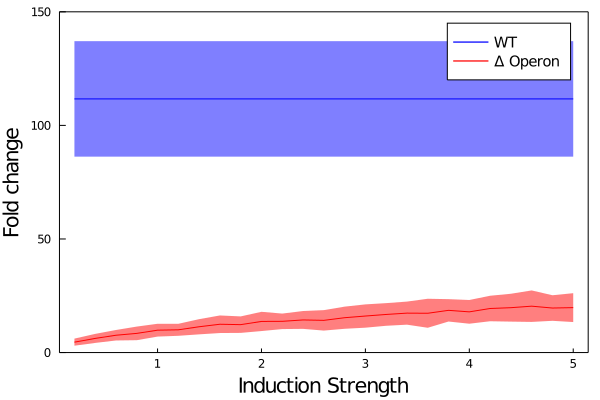

In [11]:
# Plots how the induction fold change depends on the induction strength.
# (Note that in our naive model for induction we can induce the operon however much we want, in reality there should be some maximum activity as induction strength gets large)
μs_wt = mean(fold_change_wt); σs_wt = std(fold_change_wt);
μs = mean.(fold_changes_induction); σs = std.(fold_changes_induction);

plot(induction_amounts,fill(μs_wt,length(induction_amounts)),grid=false,ribbon=fill(σs_wt,length(induction_amounts)),fillalpha=.5,label="WT",color=:blue)
fold_change_plot = plot!(induction_amounts,μs,grid=false,ribbon=σs,fillalpha=.5,ylimit=(0.,150.),framestyle=:box,label="Δ Operon",xguide="Induction Strength",yguide="Fold change",guidefontsize=14,legendfontsize=10,color=:red)

In [12]:
# Saves the figure.
savefig(fold_change_plot,figure_folder*"induced_additional_operon_only/fold_change.png")
savefig(fold_change_plot,figure_folder*"induced_additional_operon_only/fold_change.svg")

# Save Simulats as CSV

Since csv files can be more commonly read outside of the julia programming language, this section simply loads the simulation files, and re-saves them as csv files. The script only saves the value of the SigV variable, but this can be changed to either saving the RsiV or the SigV-RsiV variable. The csv saving function loads the target julia file from the data folder, and then resave it as csv (does not need to be in memory).

The csv files are structured as follow. Each csv file corresponds to one monte-carlo simulation from a model (all simulations drawn from the same distribution). The first line contains all of the time points. Then follows one line for each simulation (typically 100). The line contains comma-separated values with the amount of the component at that time point (the component is determined by which components are saved using the "vars" option, files have an appended "_SigV",  "_RsiV", or "_SigVRsiV", denoting which component int contains. 

In [13]:
# Selects which variable we wishes to save (and how we wish to change the file name correspondingly).
vars = [1];    # Selects for which variable we wishes to create csv files. 1 corresponds to SigV, 2 to RsiV, and 3 to SigV-RsiV. The vector can have several (e.g. for "vars = [1,2]" we would create files for both SigV and RsiV).

In [14]:
resave_as_cvs(data_folder*"induced_additional_operon_only/","wt_activation",vars=vars)
for ia in induction_amounts
    resave_as_cvs(data_folder*"induced_additional_operon_only/","sols_induction"*string(ia),vars=vars)
end

514.274911 seconds (79.40 M allocations: 4.244 GiB, 0.10% gc time)
